In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b master https://github.com/edsonportosilva/adaptive-signal-processing
    from os import chdir as cd
    cd('/content/notebooks/')
    ! pip install -e .
    ! pip install SciencePlots

import sympy as sp
from sympy import latex
import numpy as np
#from circuit.utils import symdisp, symplot
from IPython.display import Math, Latex, display
import matplotlib.pyplot as plt

In [2]:
from IPython.core.display import HTML
from IPython.display import Image
import scienceplots
from utils import set_preferences, genConvGIF

plt.style.use(['science','ieee'])
set_preferences()

plt.rcParams['figure.figsize'] = [5, 2.5]
#plt.rcParams['figure.dpi'] = 100

In [3]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    width:200px;
}
</style>
""")

# Introduction to Adaptive Signal Processing

## What is adaptive signal processing?

Adaptive signal processing refers to a set of techniques and algorithms that automatically adjust their parameters in response to changes in the signal or its environment. Unlike traditional signal processing methods that use fixed parameters, adaptive signal processing dynamically updates its parameters to optimize a given performance metric in real-time. 

This adaptability allows it to handle non-stationary signals and varying conditions effectively, making it ideal for applications such as noise cancellation, equalization, and system identification. 

## Applications

Adaptive signal processing has a wide range of applications across various fields. Some notable examples include:

* **System Identification**: Used to model and understand time-varying systems by adaptively adjusting the system parameters to match the observed input-output behavior, which is crucial in control systems and communications.

* **Equalization**: Applied in digital communication to compensate for signal distortion caused by channel imperfections, ensuring accurate data transmission.

* **Noise Cancellation**: Used in headphones and communication systems to reduce unwanted background noise, improving sound clarity and quality.

* **Echo Cancellation**: Employed in telecommunication systems to eliminate echo effects in phone calls, enhancing call quality.

* **Beamforming**: Utilized in antenna arrays to direct the reception or transmission of signals in specific directions, improving signal strength and reducing interference.

* **Adaptive Filtering in Medical Devices**: Used in hearing aids to adaptively filter out background noise and enhance speech signals, providing better hearing assistance.

* **Financial Market Analysis**: Employed in algorithmic trading and risk management to adapt to changing market conditions and make informed trading decisions.

* **Radar, Sonar, and Lidar Systems**: Applied to enhance target detection and tracking by adapting to varying environmental conditions and signal characteristics.

## Review of basic concepts of digital signal processing

### Discrete time signal

A continuous-time signal $x(t)$ is defined for every value of time $t$ in a given interval, i.e. it is a continuous function of $t$ where $t$ can take any value in a given range. A discrete-time version of a continuous-time signal $x(t)$ is a sequence of values $x[n]$, where $n$ is an integer ($n \in \mathbb{Z}$) and $-\infty<n<\infty$. The $x[n]$ represents the values of $x(t)$ taken at discrete instants of time. The process of converting a continuous signal into a discrete one is known as *sampling*.

To obtain the $x[n]$ from $x(t)$, the usual approach is to sample $x(t)$ periodically at a certain sampling rate. If the sampling interval is $T_s$, then the relationship between the continuous-time signal $x(t)$ and the discrete-time signal $x[n]$ is given by

$$\begin{equation}
x[n] = x(nT_s)
\end{equation}$$

where $T_s$ is the sampling period, and the sampling rate $f_s$ is the reciprocal of the sampling period, i.e

$$\begin{equation}
f_s = \frac{1}{T_s}
\end{equation}$$

### Example
Suppose we have a continuous-time signal $x(t) = e^{-8t}\sin(2 \pi f t)$. If we sample this signal at a rate $f_s$, the discrete-time signal $x[n]$ is:

$$\begin{equation}
x[n] = e^{-8nT_s}\sin(2 \pi f nT_s)
\end{equation}$$

where $T$ is the sampling period $T = \frac{1}{f_s}$.

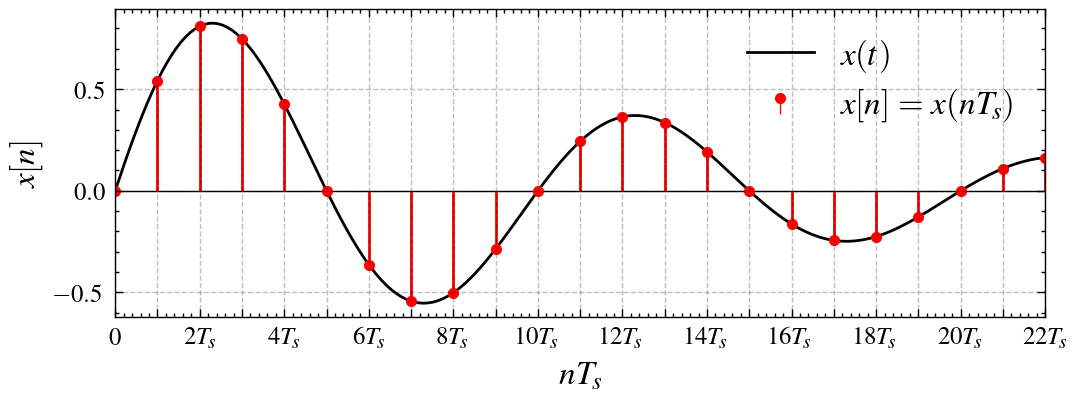

In [4]:
n = np.arange(0, 23)

f = 10
π = np.pi
fs = 100
Ts = 1/fs

xn = np.exp(-8*n*Ts)*np.sin(2*π*f*n*Ts)

t = np.linspace(0, np.max(n)*Ts, 200)
xt = np.exp(-8*t)*np.sin(2*π*f*t)

plt.figure(figsize=(6,2))
plt.hlines(0, 0, np.max(n*Ts))
plt.grid()
ax = plt.gca()
plt.plot(t, xt, label = '$x(t)$' ,linewidth = 1)

base_line = ax.plot(n*Ts, xn,'o')
markerline, stemlines, baseline = plt.stem(n*Ts, xn, base_line[0].get_color(), label = '$x[n] = x(nT_s)$', basefmt=" ")
markerline.set_markersize(3)
stemlines.set_linewidth(1)

# configure tick labels
# Turn off tick labels
ax.set_xticklabels([])
ax.set_xticks(n*Ts)
labels = [item.get_text() for item in ax.get_xticklabels()]

for ind in range(len(labels)):
    if not ind % 2:
        if ind == 0:
            labels[ind] = '$0$'
        elif ind == 1:
            labels[ind] = '$T_s$'
        else:
            labels[ind] = f'${ind}T_s$'
    else:
        labels[ind] = ' '

ax.set_xticklabels(labels)

plt.xlim(np.min(n*Ts),np.max(n*Ts))
plt.xlabel('$nT_s$')
plt.ylabel('$x[n]$')
plt.legend(loc='upper right');

To appropriately represent a continuous-time signal by its discrete-time version, the choice of the sampling rate $f_s$ is crucial. According to the Nyquist-Shannon sampling theorem, the sampling rate should be at least twice the highest frequency component present in the signal to avoid aliasing. If the sampling rate is too low, different frequency components of the signal can become indistinguishable, leading to distortion known as aliasing.

Given the discrete-time samples, the original continuous-time signal can be reconstructed if the sampling rate satisfies the Nyquist criterion and if an appropriate reconstruction filter is used. In practice, the continuous-time signal is often processed by analog-to-digital converters (ADC) to create a digital representation of the discrete-time signal, which can then be used for various digital signal processing applications.

### Discrete-time convolution 

This convolution operation is fundamental in signal processing and systems analysis, as it describes the relationship between input and output of a linear time-invariant (LTI) system. More precisely, given a discrete-time LTI system whose impulse response is given by $h[n]$, let $x[n]$ be the signal applied to the system's input, then the system's output $y[n]$ will be given by the convolution $y[n] = x[n] \ast h[n]$  which is defined as

$$
\begin{align}
y[n] &= (x \ast h)[n] \nonumber \\
     &= \sum_{k=-\infty}^{\infty} x[k] h[n - k] \nonumber\\
     &= \sum_{k=-\infty}^{\infty} h[k] x[n - k]\\
\end{align}
$$

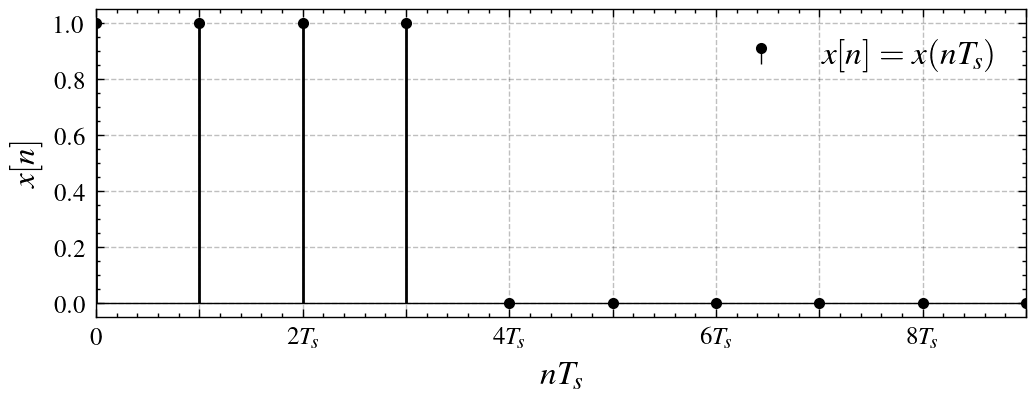

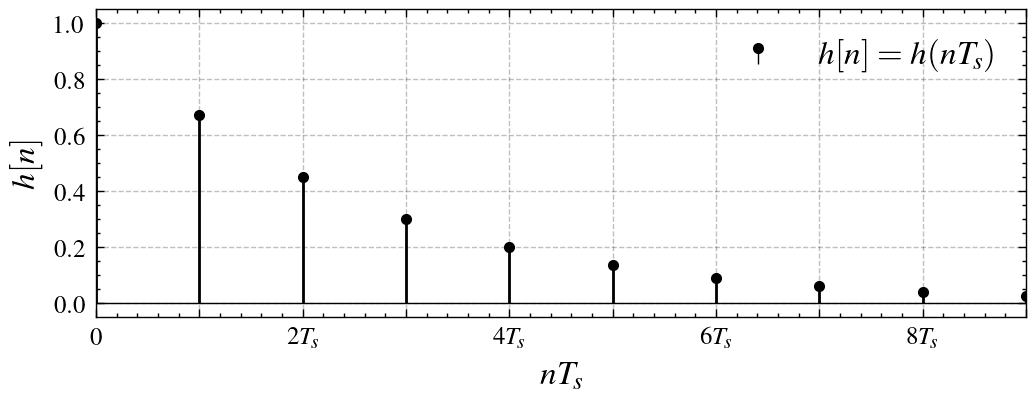

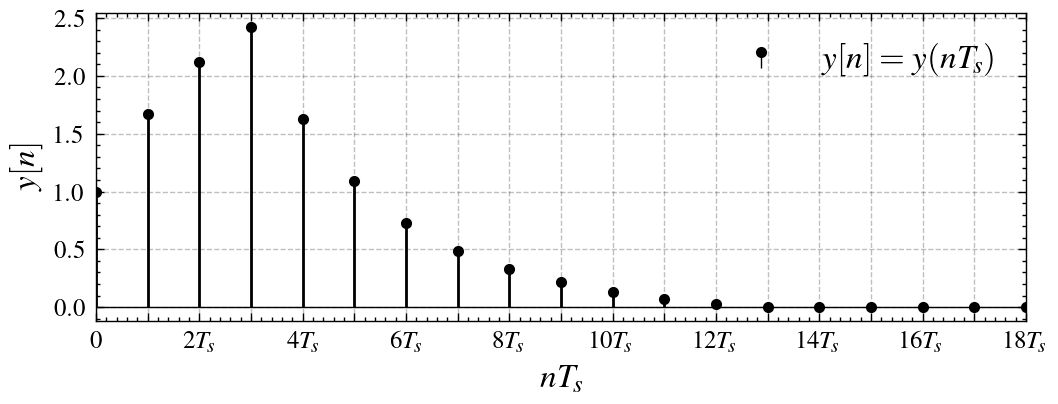

In [5]:
n = np.arange(0, 10)

f = 10
π = np.pi
fs = 100
Ts = 1/fs

xn = np.ones(n.shape)
xn[n>3] = 0

hn = np.exp(-40*n*Ts)

yn = np.convolve(hn, xn)

for ind, sig in enumerate([xn, hn, yn]):
    if ind == 0:
        case = 'x'
    elif ind == 1:
        case = 'h'
    else:
        case = 'y'
    n = np.arange(0, len(sig))
    plt.figure(figsize=(6,2))
    plt.hlines(0, 0, np.max(n*Ts))
    plt.grid()
    ax = plt.gca()
    base_line = ax.plot(n*Ts, sig,'o')
    markerline, stemlines, baseline = plt.stem(n*Ts, sig, base_line[0].get_color(), label = f'${case}[n] = {case}(nT_s)$', basefmt=" ")
    markerline.set_markersize(3)
    stemlines.set_linewidth(1)


    # configure tick labels
    # Turn off tick labels
    ax.set_xticklabels([])
    ax.set_xticks(n*Ts)
    labels = [item.get_text() for item in ax.get_xticklabels()]

    for ind in range(len(labels)):
        if not ind % 2:
            if ind == 0:
                labels[ind] = '$0$'
            elif ind == 1:
                labels[ind] = '$T_s$'
            else:
                labels[ind] = f'${ind}T_s$'
        else:
            labels[ind] = ' '

    ax.set_xticklabels(labels)

    plt.xlim(np.min(n*Ts),np.max(n*Ts))
    plt.xlabel('$nT_s$')
    plt.ylabel(f'${case}[n]$')
    plt.legend(loc='upper right');

MovieWriter ffmpeg unavailable; using Pillow instead.


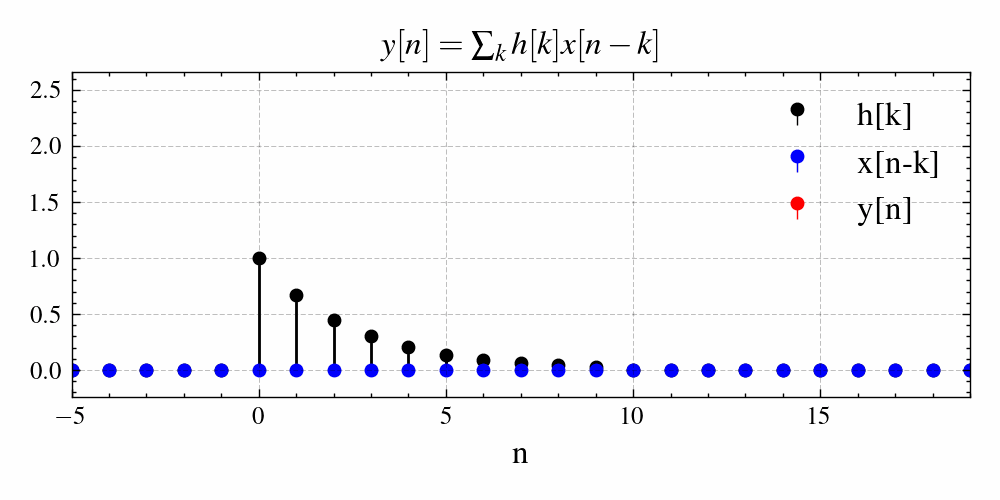

In [6]:
nStart = -5
nEnd = 20
figName = "conv_animation.gif"
xlabel = "n"
ylabel = ["x[n-k]", "h[k]", "y[n]"]
inter = 800
plotConv = True

figName  = './convolutionFig1.gif'
genConvGIF(xn, hn, nStart, nEnd, figName, xlabel, ylabel, inter)

Image('./convolutionFig1.gif', width=800)

### Discrete-time Fourier transform (DTFT)

The Discrete-Time Fourier Transform (DTFT) is a mathematical transformation used to analyze discrete-time signals in the frequency domain. It provides a way to represent a discrete-time signal as a continuous function of frequency. 

**Definition**: given a discrete-time signal $x[n]$, the DTFT is defined as

$$
\begin{equation}
X(\hat{f}) = \sum_{n=-\infty}^{\infty} x[n] e^{-j 2 \pi \hat{f} n}
\end{equation}
$$

where $\hat{f} = \frac{f}{f_s}$ is the normalized frequency, which is a continuous variable in the range $-1/2 \leq \hat{f} \leq 1/2$.

The original discrete-time signal $x[n]$ can be recovered from its DTFT $X(\hat{f})$ using the inverse DTFT, defined as

$$
\begin{equation}
x[n] = \frac{1}{2\pi} \int_{-1/2}^{1/2} X(\hat{f}) e^{j 2 \pi \hat{f}  n} \, d\hat{f}.
\end{equation}
$$

The convolution of two discrete-time signals corresponds to the multiplication of their DTFTs. If $y[n] = h[n] * x[n]$, then:
$$
\begin{equation}
Y(\hat{f}) = H(\hat{f}) X(\hat{f})
\end{equation}
$$

The total energy of the signal in the time domain is equal to the total energy in the frequency domain

$$
\begin{equation}
\sum_{n=-\infty}^{\infty} |x[n]|^2 = \int_{-1/2}^{1/2} |X(\hat{f})|^2 \, d\hat{f}
\end{equation}
$$

which is known as Parseval's relation.

### Time-Domain Sampling

Sampling a continuous-time signal $x(t)$ by multiplying it with a train of impulses and analyzing the corresponding operation in the frequency domain involves several key concepts in signal processing. When we sample a continuous-time signal $x(t)$, we multiply it by a train of impulses (also called a Dirac comb or impulse train). The impulse train $p(t)$ can be expressed as:

\begin{equation}
p(t) = \sum_{n=-\infty}^{\infty} \delta(t - nT)
\end{equation}

where $\delta(t)$ is the Dirac delta function and $T$ is the sampling period.

The sampled signal $x_s(t)$ is then:

\begin{equation}
x_s(t) = x(t) p(t) = x(t)\sum_{n=-\infty}^{\infty} \delta(t - nT)
\end{equation}

This results in a series of impulses at intervals of $T$, where the amplitude of each impulse is the value of $x(t)$ at that point.

### Frequency-Domain Analysis
To understand the effect of sampling in the frequency domain, we need to consider the Fourier transform of both the original signal $x(t)$ and the impulse train $p(t)$.

#### Fourier Transform of the Impulse Train
The Fourier transform of the impulse train $p(t)$ is another impulse train in the frequency domain:

\begin{equation}
P(f) = \frac{1}{T} \sum_{k=-\infty}^{\infty} \delta\left(f - \frac{k}{T}\right)
\end{equation}

#### Fourier Transform of the Sampled Signal
Using the convolution theorem, the Fourier transform of the sampled signal $x_s(t)$, denoted by $X_s(f)$, is the convolution of the Fourier transforms of $x(t)$ and $p(t)$:

\begin{equation}
X_s(f) = X(f) \ast P(f)
\end{equation}

Substituting $P(f)$ from above:

\begin{equation}
X_s(f) = X(f) * \frac{1}{T} \sum_{k=-\infty}^{\infty} \delta\left(f - \frac{k}{T}\right)
\end{equation}

The convolution of $X(f)$ with the impulse train results in a series of shifted copies of $X(f)$:

\begin{equation}
X_s(f) = \frac{1}{T} \sum_{k=-\infty}^{\infty} X\left(f - \frac{k}{T}\right)
\end{equation}

### Implications
1. **Periodic Replication**: The spectrum of the sampled signal $X_s(f)$ is a periodic replication of the original spectrum $X(f)$, shifted by multiples of the sampling frequency $f_s = \frac{1}{T}$.
2. **Aliasing**: If the sampling rate $f_s$ is not sufficiently high (at least twice the highest frequency component in $X(f)$, as per the Nyquist-Shannon sampling theorem), the shifted copies of $X(f)$ will overlap, causing aliasing. Aliasing results in different frequency components becoming indistinguishable in the sampled signal.

### Summary
- **Time Domain**: Sampling a continuous-time signal $x(t)$ involves multiplying it by a train of impulses, resulting in a series of samples.
- **Frequency Domain**: This operation corresponds to periodic replication of the original signal's spectrum in the frequency domain. The replicas are spaced by the sampling frequency $f_s$.
- **Nyquist Criterion**: To avoid aliasing, the sampling frequency $f_s$ must be at least twice the highest frequency component in the signal.

By understanding these relationships, we can design appropriate sampling systems and ensure accurate reconstruction of the original continuous-time signal from its samples.